### Problem Statement

The process, defined as ‘risk-based pricing’, uses a sophisticated algorithm that leverages different determining factors of a loan applicant.Selection of significant factors will help develop a prediction algorithm which can estimate loan interest rates based on clients’ information. 

- On one hand, knowing the factors will help consumers and borrowers to increase their credit worthiness and place themselves in a better position to negotiate for getting a lower interest rate.
- On the other hand, this will help lending companies to get an immediate fixed interest rate estimation based on clients information. 

Here, your goal is to use a training dataset to predict the loan rate category (1 / 2 / 3) that will be assigned to each loan in our test set.

### Data Dictionary

! [Variable Description](DataDescription.png)

### Import Libraries

In [66]:
!pip install scikit-learn==0.24.1

  Using cached https://files.pythonhosted.org/packages/16/33/e0b09b2810e355b667cd3b28850c36963735a77a431efdb2c2ca1c1c5cea/scikit_learn-0.24.1-cp37-cp37m-win_amd64.whl
  Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


ERROR: pmdarima 1.8.0 has requirement Cython<0.29.18,>=0.29, but you'll have cython 0.29.22 which is incompatible.


In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
import os
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error,roc_auc_score,accuracy_score
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold,RepeatedStratifiedKFold,GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [2]:
train = pd.read_csv('train_fNxu4vz.csv')
test = pd.read_csv('test_fjtUOL8.csv')
sample = pd.read_csv('sample_submission_HSqiq1Q.csv')

### EDA

In [3]:
print(train.shape)
print(test.shape)
print(sample.shape)

(164309, 14)
(109541, 13)
(109541, 2)


In [4]:
train.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender', 'Interest_Rate'],
      dtype='object')

In [5]:
categorical_columns = train.select_dtypes(exclude=['int', 'float']).columns
categorical_columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Income_Verified', 'Purpose_Of_Loan', 'Inquiries_Last_6Mo',
       'Number_Open_Accounts', 'Total_Accounts', 'Gender', 'Interest_Rate'],
      dtype='object')

In [6]:
numerical_columns = train.select_dtypes(include=['int', 'float']).columns
numerical_columns

Index(['Annual_Income', 'Debt_To_Income', 'Months_Since_Deliquency'], dtype='object')

1    33806
2    70580
3    59923
Name: Interest_Rate, dtype: int64


<AxesSubplot:xlabel='Interest_Rate', ylabel='count'>

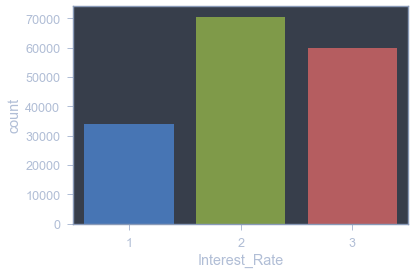

In [7]:
### Target Variable Distribution

print(train['Interest_Rate'].value_counts().sort_index())
sns.countplot(train['Interest_Rate'])

#### Missing Value Treatment , Preprocessing and Visualization

In [8]:
train.isna().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

In [9]:
test.isna().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             4936
Home_Owner                 16711
Annual_Income              16898
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    58859
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
dtype: int64

In [10]:
df = train.append(test)
df.shape

(273850, 14)

##### Loan Amount Requested

In [11]:
df['Loan_Amount_Requested'].isna().sum()

0

In [12]:
df['Loan_Amount_Requested'] = df['Loan_Amount_Requested'].str.replace(',', '').astype(int)
df['Loan_Amount_Requested'].describe()

count    273850.000000
mean      14352.992240
std        8289.036702
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: Loan_Amount_Requested, dtype: float64

<AxesSubplot:title={'center':'Loan_Amount_Requested'}, xlabel='Interest_Rate'>

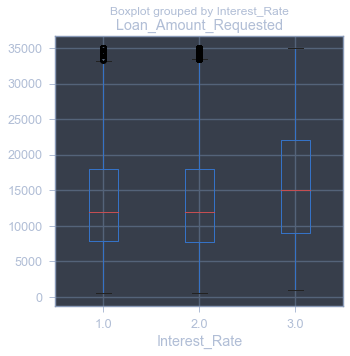

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
plt.suptitle('')
df.boxplot(column=['Loan_Amount_Requested'], by='Interest_Rate', ax=ax)

##### Length Employed

In [14]:
df['Length_Employed'].isna().sum()

12307

In [15]:
df['Length_Employed'].value_counts()

10+ years    88328
2 years      24420
3 years      21478
< 1 year     21133
5 years      18042
1 year       17336
4 years      16393
7 years      15444
6 years      15351
8 years      13115
9 years      10503
Name: Length_Employed, dtype: int64

In [16]:
df['Length_Employed'] = df['Length_Employed'].replace('10+ years','10 years')
df['Length_Employed'] = df['Length_Employed'].replace('< 1 year','0 years')

<AxesSubplot:xlabel='Length_Employed', ylabel='count'>

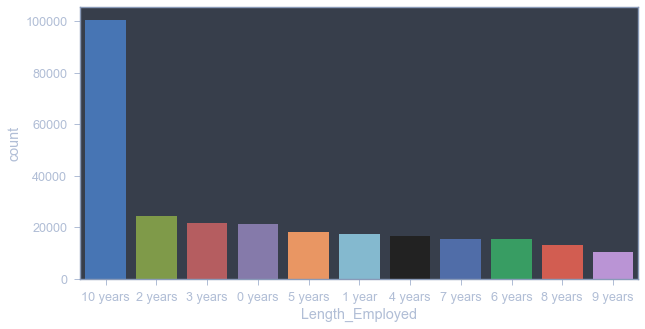

In [17]:
df['Length_Employed'].fillna(df['Length_Employed'].mode()[0],inplace = True)
plt.figure(figsize=(10,5))
sns.countplot(df['Length_Employed'],order= df['Length_Employed'].value_counts().index)

In [18]:
df[['A','B']] = df['Length_Employed'].str.split(" ",expand = True)
df['Length_Employed'] = df['A']
del df['A']
del df['B']
df['Length_Employed'] = df['Length_Employed'].astype(int)

##### Home Owner

<AxesSubplot:xlabel='Home_Owner', ylabel='count'>

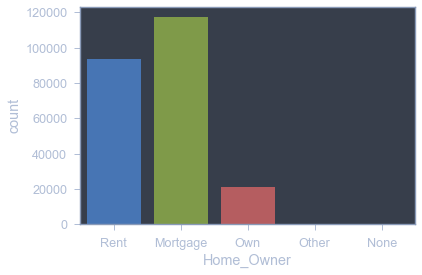

In [19]:
sns.countplot(df['Home_Owner'])

In [20]:
df['Home_Owner'].isna().sum()

42060

In [21]:
df['Home_Owner'].fillna(df['Home_Owner'].fillna(df['Home_Owner'].mode()[0]),inplace = True)

In [22]:
df['Home_Owner'].value_counts()

Mortgage    159330
Rent         93542
Own          20879
Other           79
None            20
Name: Home_Owner, dtype: int64

In [23]:
pd.crosstab(df['Home_Owner'],df['Interest_Rate'])

Interest_Rate,1.0,2.0,3.0
Home_Owner,,,
Mortgage,21584,40501,33609
None,5,1,4
Other,10,25,14
Own,2488,5416,4621
Rent,9719,24637,21675


##### Annual Income

In [24]:
df['Annual_Income'].isna().sum()

42000

36.867966687285296
3822.0975910640777


<AxesSubplot:xlabel='Annual_Income', ylabel='Density'>

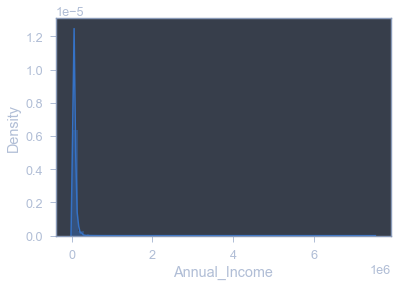

In [25]:
print(df['Annual_Income'].skew())
print(df['Annual_Income'].kurtosis())
sns.distplot(df['Annual_Income'])

In [26]:
df['Annual_Income'].fillna(df['Annual_Income'].median(),inplace = True)

##### Income Verified

In [27]:
df['Income_Verified'].value_counts()

VERIFIED - income           99076
VERIFIED - income source    88253
not verified                86521
Name: Income_Verified, dtype: int64

<AxesSubplot:xlabel='Income_Verified', ylabel='count'>

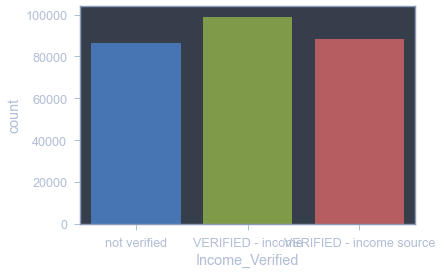

In [28]:
sns.countplot(df['Income_Verified'])

##### Purpose of Loan

<AxesSubplot:xlabel='Purpose_Of_Loan', ylabel='count'>

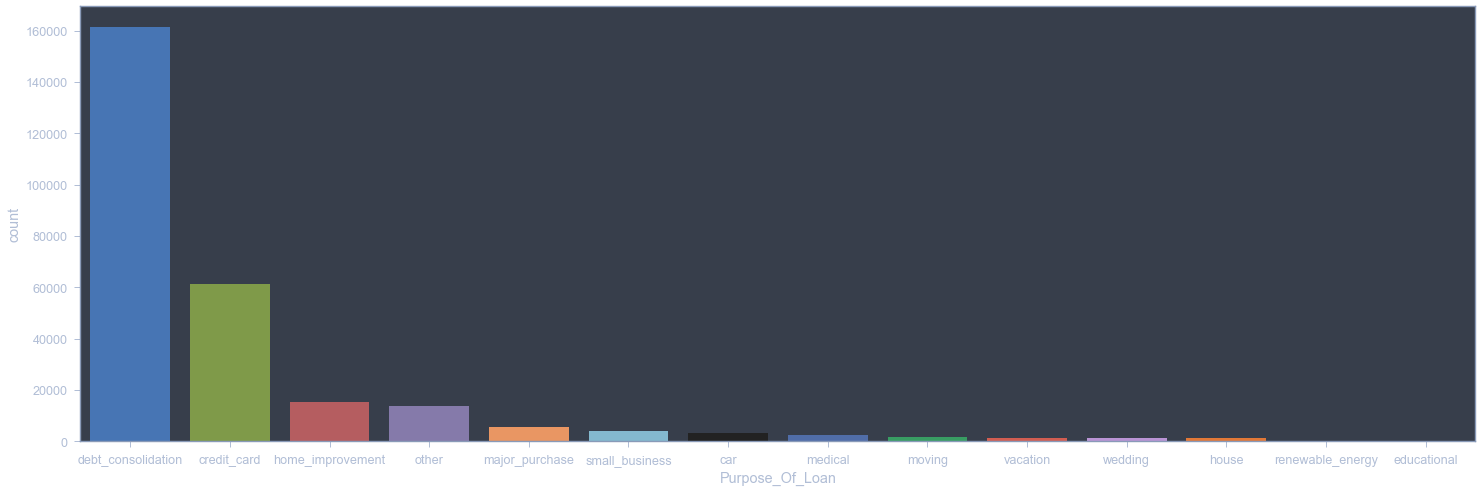

In [29]:
plt.figure(figsize=(25,8))
sns.countplot(df['Purpose_Of_Loan'],order= df['Purpose_Of_Loan'].value_counts().index)

##### Debt To Income 

0.19213205369155806
-0.5382642536274256


<AxesSubplot:xlabel='Debt_To_Income', ylabel='Density'>

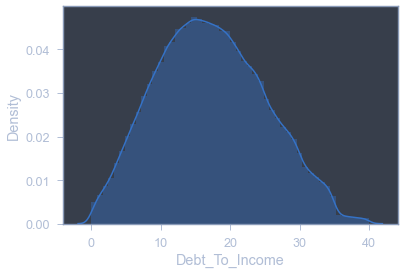

In [30]:
print(df['Debt_To_Income'].skew())
print(df['Debt_To_Income'].kurtosis())
sns.distplot(df.Debt_To_Income)

##### Inquiries SInce Last 6 months

<AxesSubplot:xlabel='Inquiries_Last_6Mo', ylabel='count'>

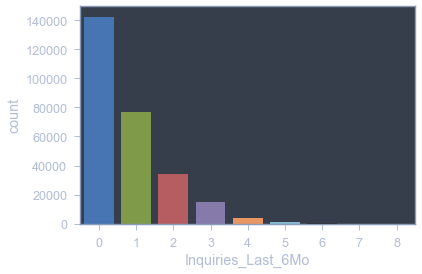

In [31]:
sns.countplot(df['Inquiries_Last_6Mo'])

##### Months Since Deliquency

In [32]:
df['Months_Since_Deliquency'].isna().sum()/len(df)*100

53.765930253788575

0.46089962944440055
-0.7363474524876565


' A negative kurtosis means that your distribution is flatter and has a lighter tail than a normal curve with the same mean and standard deviation. If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.\n'

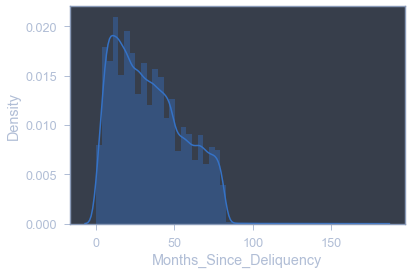

In [33]:
print(train['Months_Since_Deliquency'].skew())
print(train['Months_Since_Deliquency'].kurtosis())
sns.distplot(train['Months_Since_Deliquency'])

''' A negative kurtosis means that your distribution is flatter and has a lighter tail than a normal curve with the same mean and standard deviation. If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
'''

##### Number of Open Accounts

In [34]:
df['Number_Open_Accounts'].describe()

count    273850.000000
mean         11.186025
std           4.973663
min           0.000000
25%           8.000000
50%          10.000000
75%          14.000000
max          84.000000
Name: Number_Open_Accounts, dtype: float64

<AxesSubplot:xlabel='Number_Open_Accounts', ylabel='count'>

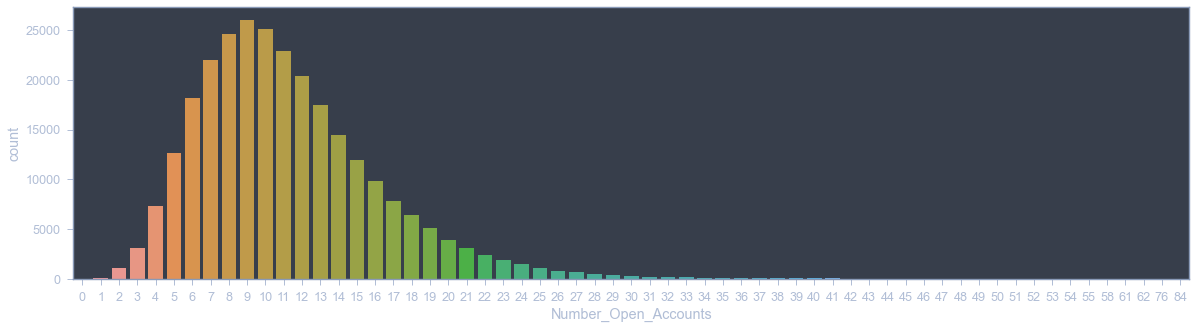

In [35]:
plt.figure(figsize = (20,5))
sns.countplot(df['Number_Open_Accounts'])

##### Total Accounts

In [36]:
plt.figure(figsize = (20,5))
##sns.countplot(df['Total_Accounts'])

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

##### Gender

In [37]:
df['Gender'].value_counts()

Male      194993
Female     78857
Name: Gender, dtype: int64

<AxesSubplot:xlabel='Gender', ylabel='count'>

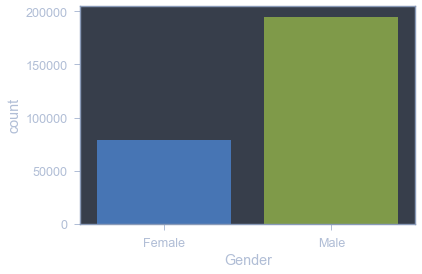

In [38]:
sns.countplot(df['Gender'])

#### New Features

In [39]:
df["Number_Invalid_Acc"] = df["Total_Accounts"] - df["Number_Open_Accounts"]
df["Number_Years_To_Repay_Debt"] = df["Loan_Amount_Requested"]/df["Annual_Income"]

In [40]:
df['Loan_label'] = pd.cut(x=df['Loan_Amount_Requested'], bins= 3, labels=['Low','Medium','High'], right=True)
dic = {'Low':1,'Medium':2,'High':3}
df['Loan_label'] = df['Loan_label'].map(dic)

In [41]:
df['Income_label'] = pd.cut(x=df['Annual_Income'], bins= 3, labels=['Low','Medium','High'], right=True)
dic = {'Low':1,'Medium':2,'High':3}
df['Income_label'] = df['Income_label'].map(dic)

In [42]:
deli = []
for i in df['Months_Since_Deliquency']:
    if pd.isnull(i) == True:
        deli.append(0)
    else:
        deli.append(1)
df['Deliquency'] = deli
df.drop('Months_Since_Deliquency',axis = 1,inplace = True)

#### Complete EDA

In [43]:
df = df[['Loan_ID','Loan_Amount_Requested','Length_Employed','Home_Owner',
         'Annual_Income','Income_Verified','Purpose_Of_Loan','Debt_To_Income',
         'Inquiries_Last_6Mo','Number_Open_Accounts','Total_Accounts','Gender',
         'Number_Invalid_Acc','Number_Years_To_Repay_Debt','Interest_Rate','Income_label','Loan_label','Deliquency']]

In [44]:
trains = df[df['Interest_Rate'].isna() == False] 
tests = df[df['Interest_Rate'].isna() == True]

In [45]:
trains['Interest_Rate'] = trains['Interest_Rate'].astype(int)

In [46]:
trains.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Number_Invalid_Acc,Number_Years_To_Repay_Debt,Interest_Rate,Income_label,Loan_label,Deliquency
0,10000001,7000,0,Rent,68000.0,not verified,car,18.37,0,9,14,Female,5,0.102941,1,1,1,0
1,10000002,30000,4,Mortgage,63000.0,VERIFIED - income,debt_consolidation,14.93,0,12,24,Female,12,0.476190,3,1,3,1
2,10000003,24725,7,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,12,16,Male,4,0.327196,3,1,3,0
3,10000004,16000,0,Mortgage,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,16,22,Male,6,0.284900,3,1,2,0
4,10000005,17000,8,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,19,30,Female,11,0.177083,1,1,2,0


#### Insights

In [47]:
trains.groupby('Length_Employed')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std']).sort_values(by='median')

,count,min,max,mean,median,std
Length_Employed,,,,,,
0,12805,500,35000,13073.049590,11200.0,8065.617881
1,10422,725,35000,13242.355114,11500.0,7980.595155
2,14620,800,35000,13592.093023,12000.0,8067.727029
3,12974,500,35000,13699.460459,12000.0,8011.624766
4,9784,900,35000,13733.130621,12000.0,7972.669287
5,10814,1000,35000,13850.906233,12000.0,8043.100489
6,9094,1000,35000,14103.216406,12000.0,8004.244626
7,9308,1000,35000,14439.637946,12762.5,8068.943753
8,7917,1000,35000,14517.361374,12975.0,8135.982141


In [48]:
trains.groupby('Home_Owner')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std']).sort_values(by='median')

,count,min,max,mean,median,std
Home_Owner,,,,,,
Other,49,1000,35000,10642.857143,10000,6569.131570
None,10,2800,15000,9420.000000,10375,3766.533921
Rent,56031,500,35000,12443.831986,10625,7413.272921
Own,12525,900,35000,13567.704591,12000,8135.510763
Mortgage,95694,500,35000,15569.770832,14500,8555.801557


In [49]:
trains.groupby('Purpose_Of_Loan')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std']).sort_values(by='median')

,count,min,max,mean,median,std
Purpose_Of_Loan,,,,,,
vacation,837,500,35000,6300.627240,5000.0,5033.519112
moving,974,1000,35000,7668.814168,5375.0,6418.661738
car,1885,1000,35000,8053.806366,6000.0,5608.118313
educational,121,1000,25000,7110.123967,6000.0,4871.189300
medical,1541,1000,35000,8913.854640,6850.0,6923.468955
other,8346,500,35000,9635.493051,7662.5,7348.544112
major_purchase,3435,1000,35000,10394.657933,8000.0,7929.416404
wedding,828,1000,35000,10239.402174,8500.0,6519.794539
renewable_energy,123,1000,35000,10958.130081,10000.0,7810.495970


In [50]:
trains.groupby('Interest_Rate')['Loan_Amount_Requested'].agg(['count','min','max','mean','median','std']).sort_values(by='mean')

,count,min,max,mean,median,std
Interest_Rate,,,,,,
1,33806,500,35000,13351.443531,12000,7307.255920
2,70580,500,35000,13419.251913,12000,7759.823178
3,59923,1000,35000,16007.801679,15000,9093.711445


In [51]:
trains.groupby('Interest_Rate')['Annual_Income'].agg(['count','min','max','mean','median','std']).sort_values(by='median')

,count,min,max,mean,median,std
Interest_Rate,,,,,,
1,33806,5000.0,4900000.0,78503.289623,63000.0,56552.869715
2,70580,4000.0,7141778.0,69936.895009,63000.0,54506.035531
3,59923,4800.0,7500000.0,70083.414592,63000.0,56309.359278


### Modelling

In [85]:
df_new = trains.append(tests)

In [86]:
cat_columns = ['Home_Owner','Income_Verified','Purpose_Of_Loan','Gender']
le = LabelEncoder() 

for columns in cat_columns:
    df_new[columns]= le.fit_transform(df_new[columns]) 

In [87]:
df_new = pd.get_dummies(df_new)
train_df = df_new[df_new['Interest_Rate'].isna() == False].drop("Loan_ID",axis=1)
test_df = df_new[df_new['Interest_Rate'].isna() == True]

In [88]:
train_df.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,...,Number_Invalid_Acc,Number_Years_To_Repay_Debt,Interest_Rate,Deliquency,Income_label_1,Income_label_2,Income_label_3,Loan_label_1,Loan_label_2,Loan_label_3
0,7000,0,4,68000.0,2,0,18.37,0,9,14,...,5,0.102941,1.0,0,1,0,0,1,0,0
1,30000,4,0,63000.0,0,2,14.93,0,12,24,...,12,0.476190,3.0,1,1,0,0,0,0,1
2,24725,7,0,75566.4,1,2,15.88,0,12,16,...,4,0.327196,3.0,0,1,0,0,0,0,1
3,16000,0,0,56160.0,1,2,14.34,3,16,22,...,6,0.284900,3.0,0,1,0,0,0,1,0
4,17000,8,3,96000.0,1,2,22.17,1,19,30,...,11,0.177083,1.0,0,1,0,0,0,1,0


In [76]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['Interest_Rate'], axis = 1), 
                                                    train_df['Interest_Rate'], test_size = 0.2, 
                                                    random_state = 2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(131447, 20) (32862, 20) (131447,) (32862,)


In [89]:
test_df.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,...,Number_Invalid_Acc,Number_Years_To_Repay_Debt,Interest_Rate,Deliquency,Income_label_1,Income_label_2,Income_label_3,Loan_label_1,Loan_label_2,Loan_label_3
0,10164310,27500,10,0,129000.0,0,2,12.87,0,10,...,27,0.213178,NaN,1,1,0,0,0,0,1
1,10164311,26000,10,0,110000.0,2,1,11.37,0,6,...,17,0.236364,NaN,0,1,0,0,0,0,1
2,10164312,6075,0,4,75000.0,0,2,6.83,2,5,...,15,0.081000,NaN,0,1,0,0,1,0,0
3,10164313,12000,10,0,73000.0,1,2,7.76,0,6,...,2,0.164384,NaN,0,1,0,0,1,0,0
4,10164314,35000,0,0,156000.0,2,2,9.62,0,9,...,12,0.224359,NaN,1,1,0,0,0,0,1


In [56]:
model_logreg = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100,10,1,0.1]
grid1 = dict(solver= solvers, penalty= penalty,C=c_values)

cv = RepeatedStratifiedKFold(n_splits= 5,n_repeats=3,random_state=1)
grid_search = GridSearchCV(estimator=model_logreg, param_grid=grid1, n_jobs=-1, cv=cv, scoring="accuracy", verbose=1, error_score=0)
grid_result = grid_search.fit(X_train,y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 15 folds for each of 12 candidates, totalling 180 fits
Best: 0.505380 using {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [90]:
logreg = LogisticRegression(solver = 'newton-cg' ,penalty='l2',C= 1)
logreg.fit(train_df.drop(['Interest_Rate'], axis = 1), train_df[['Interest_Rate']])
pickle.dump(logreg, open('logisticRegression.pkl','wb'))

In [106]:
test_df.to_csv("test_dataset.csv",index=False)